In [1]:
from utils import *
import torch.nn as nn
from torch.utils.checkpoint import checkpoint
from pickle import dump
import os 
#os.environ['PYTORCH_NO_CUDA_MEMORY_CACHING'] = '1'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:21"

/home/xuyuqi/.conda/envs/minimind/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def Coordinate_descend_genep(dim, comp_dim):
    assert dim >= comp_dim, "compression dimension must be smaller than dimension"
    ide = torch.eye(dim, requires_grad=False)
    select_col = torch.randperm(dim)[:comp_dim]
    sign = torch.randint(0, 2, (comp_dim, ))
    sign = sign * 2 - 1
    # XXX make clear whether PTP is I or PPT is I
    P = ide[:, select_col] * sign
    return P

def mem():
    #torch.cuda.empty_cache()
    print('memory allocated: ' + str((torch.cuda.memory_allocated() / 1024)) )
    print('memory reserved: ' + str(torch.cuda.memory_reserved() / 1024) )
    print('max memory allocated: ' + str(torch.cuda.max_memory_allocated() / 1024) )
    print('max memory reserved: ' + str(torch.cuda.max_memory_reserved() / 1024) )

class SubScafLinearTest(nn.Module):
    """
    Linear network with compressed dimension
    """
    def __init__(self, comp_dim: int, comp_mat: torch.Tensor, wraped_model: nn.Linear):
        self.comp_mat = comp_mat
        self.comp_dim = comp_dim
        device = wraped_model.weight.device
        dtype = wraped_model.weight.dtype
        factory_kwargs = {'device': device, 'dtype': dtype}
        self.x = wraped_model.weight.detach().clone()
        super().__init__()
        self.b = nn.Parameter(torch.zeros((comp_dim, wraped_model.in_features), **factory_kwargs))
    
    def comp_mul(self, b):
        return self.comp_mat @ b + self.x

    def forward(self, input):
        #def compute_linear(input):
            #weight = self.comp_mat @ self.b + self.x
            #return F.linear(input, weight)
        #return checkpoint(compute_linear, input, use_reentrant=False)
        mem()
        x = F.linear(self.comp_mat, self.b.T)
        print(x.grad_fn)
        mem()
        x = self.x + x
        print(x.grad_fn)
        mem()
        output = F.linear(input, x)
        print(output.grad_fn)
        mem()
        return output 

class SubScafLayer(nn.Module):
    def __init__(self, comp_dim, comp_mat, wraped_model):
        super().__init__()
        self.layer1 = SubScafLinearTest(comp_dim, comp_mat, wraped_model)
        self.layer2 = SubScafLinearTest(comp_dim, comp_mat, wraped_model)
    
    def forward(self, input):
        x = checkpoint(self.layer1, input)
        x = self.layer2(x)
        return x

In [3]:
comp_dim = 64
wraped_module = nn.Linear(512, 512, bias=False)
comp_mat = Coordinate_descend_genep(wraped_module.out_features, comp_dim)
model = SubScafLinearTest(comp_dim, comp_mat, wraped_module)

activation_values = []
def hook(module, input, output):
    activation_values.append(output.detach().clone())
handle = model.register_forward_hook(hook)

In [3]:
#torch.cuda.memory._record_memory_history(enabled='all')
device = "cuda:0"
comp_dim = 64
wraped_module = nn.Linear(512, 512, bias=False).to(device)
comp_mat = Coordinate_descend_genep(wraped_module.out_features, comp_dim).to(device)
model = SubScafLinearTest(comp_dim, comp_mat, wraped_module).to(device)
input_data = torch.eye(512).to(device)
output = model(input_data)
mem()
output.sum().backward()
opt = torch.optim.SGD(model.parameters())
opt.zero_grad()
#s = torch.cuda.memory._snapshot()
#with open(f"snapshot.pickle", "wb") as f:
    #dump(s, f)

memory allocated: 3328.0
memory allocated: 12672.0
memory allocated: 12672.0
memory allocated: 13696.0
memory allocated: 12672.0


In [27]:

output = model(input_data)
mem()
output.sum().backward()
del output
mem()

memory allocated: 19968.0
memory allocated: 19072.0


In [3]:
#torch.cuda.memory._record_memory_history(enabled='all')
device = "cuda:0"
comp_dim = 64
wraped_module = nn.Linear(512, 512, bias=False).to(device)
comp_mat = Coordinate_descend_genep(wraped_module.out_features, comp_dim).to(device)
model = SubScafLayer(comp_dim, comp_mat, wraped_module).to(device)
del wraped_module
mem()
input_data = torch.eye(512).to(device)
mem()
output = model(input_data)
mem()
#del output
output.sum().backward()
mem()
#s = torch.cuda.memory._snapshot()
#with open(f"snapshot.pickle", "wb") as f:
    #dump(s, f)

memory allocated: 2432.0
memory reserved: 4096.0
max memory allocated: 3456.0
max memory reserved: 4096.0
memory allocated: 3456.0
memory reserved: 4096.0
max memory allocated: 3456.0
max memory reserved: 4096.0
memory allocated: 3456.0
memory reserved: 4096.0
max memory allocated: 3456.0
max memory reserved: 4096.0
None
memory allocated: 12800.0
memory reserved: 26624.0
max memory allocated: 12800.0
max memory reserved: 26624.0
None
memory allocated: 12800.0
memory reserved: 26624.0
max memory allocated: 13824.0
max memory reserved: 26624.0
None
memory allocated: 13824.0
memory reserved: 26624.0
max memory allocated: 13824.0
max memory reserved: 26624.0
memory allocated: 12800.0
memory reserved: 26624.0
max memory allocated: 13824.0
max memory reserved: 26624.0
memory allocated: 13824.0
memory reserved: 26624.0
max memory allocated: 13824.0
max memory reserved: 26624.0
memory allocated: 13824.0
memory reserved: 28672.0
max memory allocated: 14848.0
max memory reserved: 28672.0
memory 

/home/xuyuqi/.conda/envs/minimind/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/xuyuqi/.conda/envs/minimind/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [3]:
device = "cuda:0"
mem()
model = nn.Linear(32, 32, bias=False).to(device)
mem()
input_data = torch.randn((1, 32)).to(device)
mem()
output = model(input_data)
#with torch.no_grad():
    #output = model(input_data)
mem()

output.sum().backward()

mem()

memory allocated: 0.0
memory reserved: 0.0
max memory allocated: 0.0
max memory reserved: 0.0
memory allocated: 4.0
memory reserved: 2048.0
max memory allocated: 4.0
max memory reserved: 2048.0
memory allocated: 4.5
memory reserved: 2048.0
max memory allocated: 4.5
max memory reserved: 2048.0
memory allocated: 8325.0
memory reserved: 22528.0
max memory allocated: 8325.0
max memory reserved: 22528.0
memory allocated: 16649.0
memory reserved: 22528.0
max memory allocated: 16650.5
max memory reserved: 22528.0


In [7]:
from transformers import (
    AutoTokenizer,
    AutoConfig,
    LlamaConfig,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    get_cosine_schedule_with_warmup,
)
import os 
os.environ['HF_ENDPOINT'] = "https://hf-mirror.com"
#model_config = AutoConfig.from_pretrained("openai-community/gpt2")

tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Error while downloading from https://hf-mirror.com/openai-community/gpt2/resolve/main/model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf-mirror.com', port=443): Read timed out.
Trying to resume download...


In [8]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [11]:
import numpy as np
def Coordinate_descend_genep(d, r, n=1):
    sum_p = np.zeros((d, r)) 
    for _ in range(n):
        ide = np.eye(d)
        col_num = np.arange(d)
        select_col = np.random.choice(col_num, r, replace=False)
        sign = np.random.choice([-1, 1], r)
        P = np.sqrt(d / r) * ide[:, select_col] * sign
        #P = ide[:, select_col] * sign
        sum_p += P
    P = sum_p / n
    return P


def Spherical_smoothing_genep(d, r, n=1):
    sum_p = np.zeros((d, r)) 
    for _ in range(n):
        z = np.random.randn(d, d)
        Q, R = np.linalg.qr(z)
        D = np.diag(np.sign(np.diag(R)))
        Q = Q @ D
        R = D @ R
        assert np.allclose(Q @ R, z, atol=1e-7), "the QR decomposion is not accuracy"
        #P = np.sqrt(d / r) * Q[:, :r]
        P = Q[:, :r]
        sum_p += P
    P = sum_p / n
    return P

def gene_random_matrix(in_dim, out_dim):
    return np.random.randn(in_dim, out_dim) / np.sqrt(out_dim)

In [12]:
import numpy as np
worker_num = 20
total_sample_size = 1000
d = 10
def genHeLS(total_sample_size, d, worker_num):
    assert total_sample_size % worker_num == 0, "please make sure total_sample can be divided for each worker equally"
    mean = np.random.uniform(low=-1, high=1, size=worker_num)
    scale = np.sqrt(np.random.uniform(low=0.5, high=1.5, size=worker_num))
    a_list = []
    for i in range(worker_num):
        a_list.append(np.random.normal(loc=mean[i], scale=scale[i], size=(total_sample_size // worker_num, d)))
    a = np.concatenate(a_list, axis=0)
    ans = np.random.randn(d, 1)
    b = a @ ans + 0.1 * np.random.randn(total_sample_size, 1)
    return a, b

def solLS(A, b):
    x_sol = np.linalg.inv(A.T@A)@(A.T@b)
    print(A.T@(A@x_sol-b) / len(A))
    return x_sol

In [13]:
pcd = Coordinate_descend_genep(10, 5)
pss = Spherical_smoothing_genep(10, 5)
prd = gene_random_matrix(10, 5)

pcd.T @ pcd

array([[2., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0.],
       [0., 0., 2., 0., 0.],
       [0., 0., 0., 2., 0.],
       [0., 0., 0., 0., 2.]])

In [6]:
np.sum(prd, axis=0)

array([-0.07551295, -0.43366106,  0.36777972,  0.63740934,  0.45284414])

In [25]:
import torch
from utils import Coordinate_descend_genep
def set_seed(seed):
    # Set random seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
#set_seed(42)
Coordinate_descend_genep(5, 10)

tensor([[-0., -0., -1., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -1., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -1.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -1., -0.],
        [-0., -0., -0., -0., -1., -0., -0., -0., -0., -0.]])

In [1]:
import torch
def Coordinate_descend_genep(comp_dim, dim):
    assert dim >= comp_dim, "compression dimension must be smaller than dimension"
    ide = torch.eye(dim)
    select_row = torch.randperm(dim)[:comp_dim].sort().values
    sign = torch.randint(0, 2, (comp_dim, ))
    sign = sign * 2 - 1
    #P = torch.sqrt(torch.tensor(dim / comp_dim)) * ide[select_row, :] * sign.unsqueeze(1)
    P = ide[select_row, :] * sign.unsqueeze(1)
    return P

In [11]:
Coordinate_descend_genep(5, 10)

tensor([[-1., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-0., -0., -0., -1., -0., -0., -0., -0., -0., -0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]])

In [ ]:
import utils.resnet_module as resnet
import torch.nn as nn
import torchvision.models as models
from utils import replace_with_subscaf_layer
from utils import subscafconv2d

In [ ]:
subscaf_class = subscafconv2d
replace_class = nn.Conv2d
import torch.distributed as dist
comp_mat_rec = []
def replace_module(model, target_modules_list, jump_modules_list=None):
    """replace Conv2d/Linear modules in model into SubScafConv2d/SubScafLinear module"""
    for name, module in model.named_children():
        # only revise module with param_name has "mlp" or "attn"
        if isinstance(module, replace_class) and any(target_key in name for target_key in target_modules_list):
            log(f"enable Subspace Scaffold for weights in module: {name}")
            if args.adaptive_cp_rate != 0:
                record_cp_dim = args.comp_dim
                args.comp_dim = min(max(int(module.in_features * args.adaptive_cp_rate), args.comp_dim), module.in_features)

            # create compression matrix only when new shape demand occur
            if (args.comp_dim, module.in_features) not in comp_mat_rec.keys():
                #comp_mat = gene_random_matrix(module.out_features, args.comp_dim, args.gene_method).to(device)
                comp_mat = gene_random_matrix(args.comp_dim, module.in_features, args.gene_method).to(device)
                comp_mat = comp_mat.to(module.weight.dtype)
                dist.broadcast(comp_mat, src=0)
                comp_mat_rec[(args.comp_dim, module.in_features)] = comp_mat
            else:
                comp_mat = comp_mat_rec[(args.comp_dim, module.in_features)]

            # substitue all Conv2d/Linear module into SubScafConv2d/SubScafLinear module
            new_layer = subscaf_class(args.comp_dim, comp_mat, module)

            setattr(model, name, new_layer)

            # initialize lambda
            #lbd.append(torch.zeros((args.comp_dim, module.in_features), device=device, requires_grad=False))
            layer_lbd = torch.zeros((module.out_features, args.comp_dim), device=device, requires_grad=False, dtype=module.weight.dtype)
            # in_features is needed for optimizer later
            layer_lbd.in_features = module.in_features
            lbd.append(layer_lbd)
            if args.adaptive_cp_rate != 0:
                # recover compression dimension
                args.comp_dim = record_cp_dim

        else:
            if args.jump_certain_modules and name in jump_modules_list:
                continue
            replace_module(module, target_modules_list, jump_modules_list)

In [ ]:
model = resnet.__dict__['resnet1202']()

/home/xuyuqi/.conda/envs/minimind/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xuyuqi/.conda/envs/minimind/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /home/xuyuqi/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:02<00:00, 81.4MB/s] 


In [22]:
for name, module in model.named_children():
    if isinstance(module, nn.Sequential):
        #print(name)
        for n, m in module.named_children():
            print(n)
            print(m)
            print('\n')

0
BasicBlock(
  (conv1): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential()
)


1
BasicBlock(
  (conv1): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential()
)


2
BasicBlock(
  (conv1): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con

In [2]:
def mem_comp(batch_size, seq_length, comp_dim):
    sgd_mem = 36 * 512 ** 2 * 8 + 2 * 32000 * 512 + batch_size * 8 * (16 * seq_length ** 2 + 14 * 512 * seq_length)
    subscaf_mem = (24 * 512 ** 2 + 12 * 512 * comp_dim)* 8 + 6 * 32000 * 512 + \
        batch_size * 8 * (16 * seq_length ** 2 + (4 + 8 * (1 - comp_dim / 512)) * 512 * seq_length)
    return sgd_mem * 4 / (1024 ** 3), subscaf_mem * 4 / (1024 ** 3)

mem_comp(32, 1024 ,128)


(23.4033203125, 21.5771484375)

In [7]:
comp_dim = 128
batch_size = 32
seq_length = 1024
p1 = (24 * 512 ** 2 + 12 * 512 * comp_dim)* 8 + 6 * 32000 * 512
p2 = batch_size * 8 * (16 * seq_length ** 2 + (4 + 8 * (1 - comp_dim / 512)) * 512 * seq_length)
p2 = batch_size * 8 * (16 * seq_length ** 2 + 14 * 512 * seq_length)
p2 / (p1 + p2)

0.975520854906184

In [9]:
16 * seq_length ** 2/(16 * seq_length ** 2 + 14 * 512 * seq_length)

0.6956521739130435

In [13]:
0.97 * 3 / 7

0.41571428571428576

ConversionError: Failed to convert value(s) to axis units: ['LLaMA-60m', 'LLaMA-350M', 'LLaMA-1b']

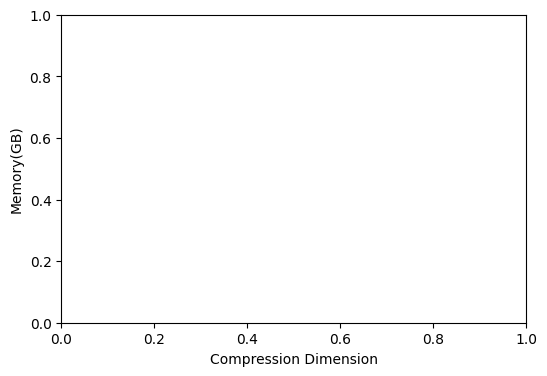

In [ ]:
import matplotlib.pyplot as plt
model_name = ["LLaMA-60m", "LLaMA-350M", "LLaMA-1b"]
cd64_memory = [39.461, 50.272, 53.566]
cd128_memory = [39.924, 51.087, 54.184]
cd256_memory = [40.851, 52.705, 55.464]
pki_memory = [43.601, 65.324, None]
fedavg_mem = [43.209, 60.785, 59.177]

plt.figure(figsize=(6, 4))
#plt.title(title)
plt.xlabel('Compression Dimension')
plt.ylabel('Memory(GB)')
plt.xticks(model)
plt.ylim([0, 70])

plt.bar(model, cd64_memory, width=30, label='Our-CD64')
plt.bar(model, cd128_memory, width=30, label='Our-CD128')
plt.bar(model, cd256_memory, width=30, label='Our-CD256')
plt.bar(model, pki_memory, width=30, label=r'Our-P^k=I')
plt.bar(model, fedavg_mem, width=30, label='FedAvg')
plt.legend()
plt.savefig("logs/csv/mem.png")
plt.show()
plt.close()

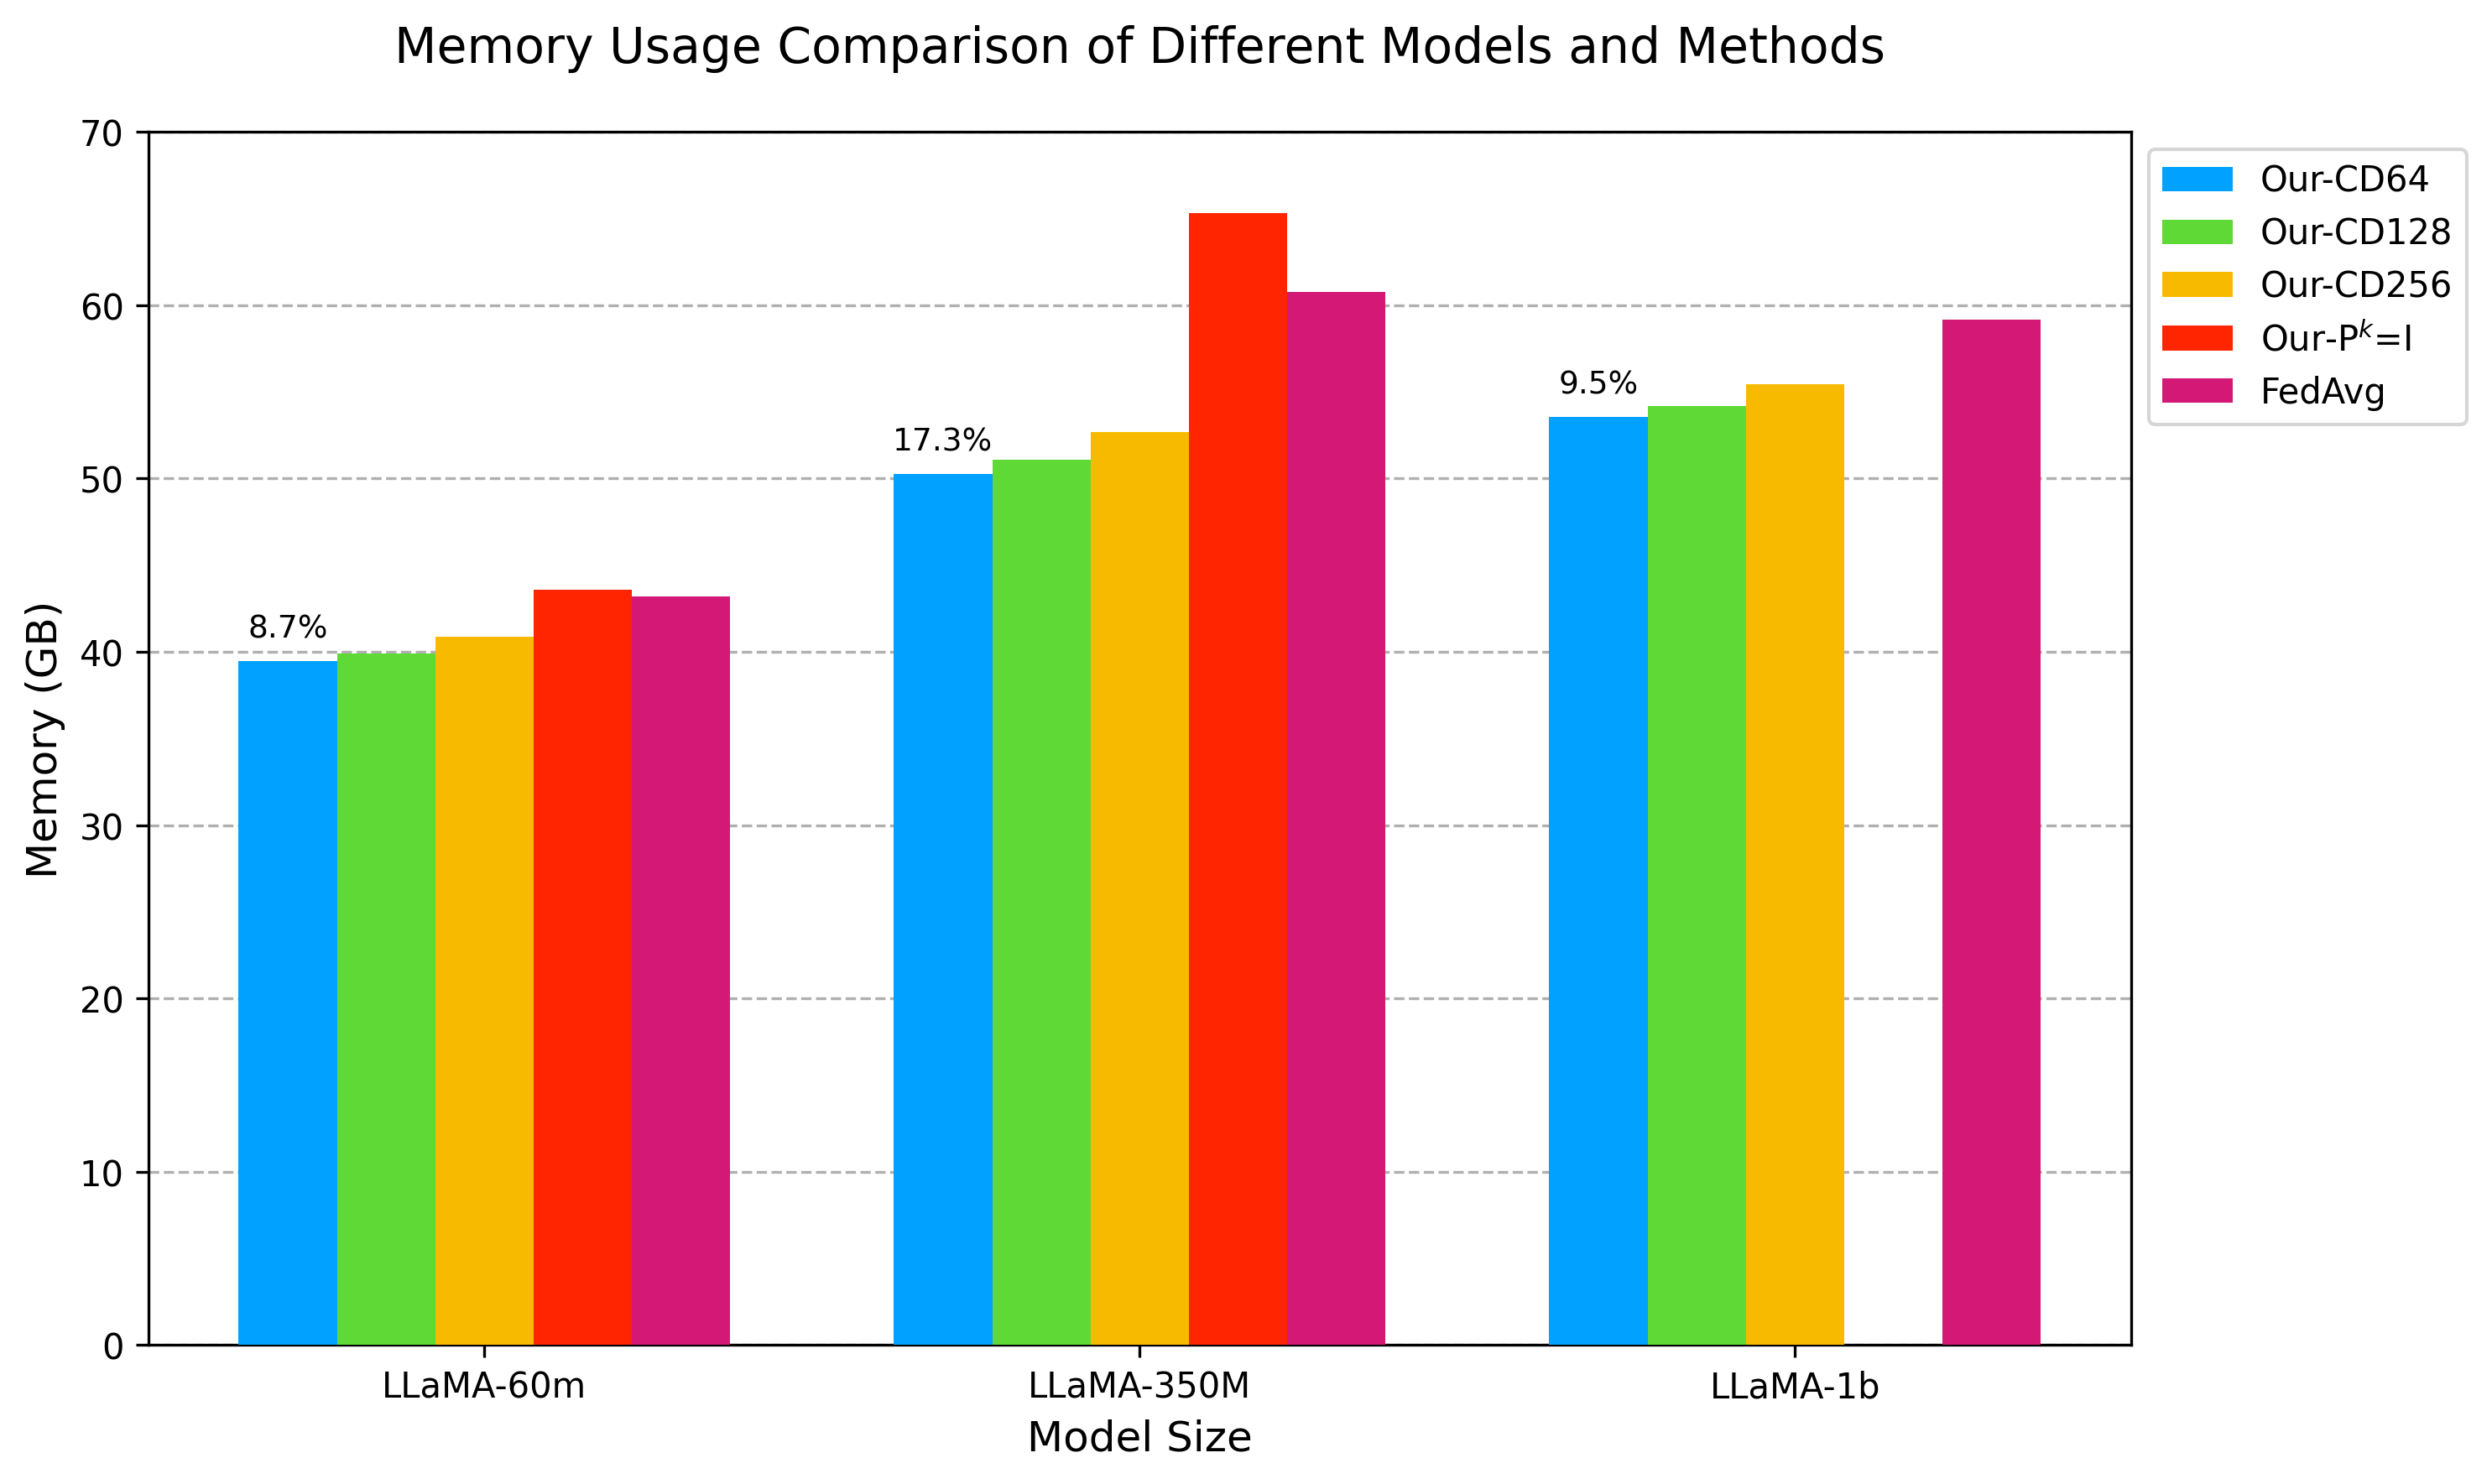

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 数据定义
model_name = ["LLaMA-60m", "LLaMA-350M", "LLaMA-1b"]
cd64_memory = [39.461, 50.272, 53.566]
cd128_memory = [39.924, 51.087, 54.184]
cd256_memory = [40.851, 52.705, 55.464]
pki_memory = [43.601, 65.324, np.nan]  # 将None替换为np.nan
fedavg_mem = [43.209, 60.785, 59.177]

# 计算 Our-CD64 相对于 FedAvg 的内存节省比例
def cal_save_ratio(cd64, fedavg):
    ratios = []
    for c, f in zip(cd64, fedavg):
        if not np.isnan(f) and f != 0:
            ratio = (f - c) / f * 100
            ratios.append(ratio)
        else:
            ratios.append(np.nan)
    return ratios

save_ratios = cal_save_ratio(cd64_memory, fedavg_mem)

# 设置图形大小和分辨率
plt.figure(figsize=(10, 6), dpi=300)

# 绘制柱状图
x = np.arange(len(model_name))  # x轴位置
width = 0.15  # 柱子宽度

bar_cd64 = plt.bar(x - 2 * width, cd64_memory, width, label='Our-CD64', color='#00A1FF', zorder=3)
bar_cd128 = plt.bar(x - width, cd128_memory, width, label='Our-CD128', color='#5ed935', zorder=3)
bar_cd256 = plt.bar(x, cd256_memory, width, label='Our-CD256', color='#f8ba00', zorder=3)
bar_pki = plt.bar(x + width, pki_memory, width, label=r'Our-P$^k$=I', color='#ff2501', zorder=3)
bar_fedavg = plt.bar(x + 2 * width, fedavg_mem, width, label='FedAvg', color='#d31876', zorder=3)

# 设置图表标题和坐标轴标签
plt.title('Memory Usage Comparison of Different Models and Methods', fontsize=14, pad=20)
plt.xlabel('Model Size', fontsize=12)
plt.ylabel('Memory (GB)', fontsize=12)

# 设置x轴刻度和标签
plt.xticks(x, model_name, fontsize=10)

# 设置y轴范围和网格线
plt.ylim([0, 70])
plt.grid(axis='y', linestyle='--', zorder=0)

# 添加图例
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# 添加节省比例文本标注
for i, ratio in enumerate(save_ratios):
    if not np.isnan(ratio):
        # 计算文本位置，在 Our-CD64 柱状图上方合适位置
        bar_height = bar_cd64[i].get_height()
        plt.text(bar_cd64[i].get_x() + bar_cd64[i].get_width() / 2, 
                 bar_height + 1,  # 距离柱状图顶部的垂直距离
                 f'{ratio:.1f}%',  # 保留1位小数
                 ha='center', va='bottom', fontsize=9, color='black')

# 优化布局
plt.tight_layout()

# 保存图像并显示
plt.savefig("logs/csv/mem.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

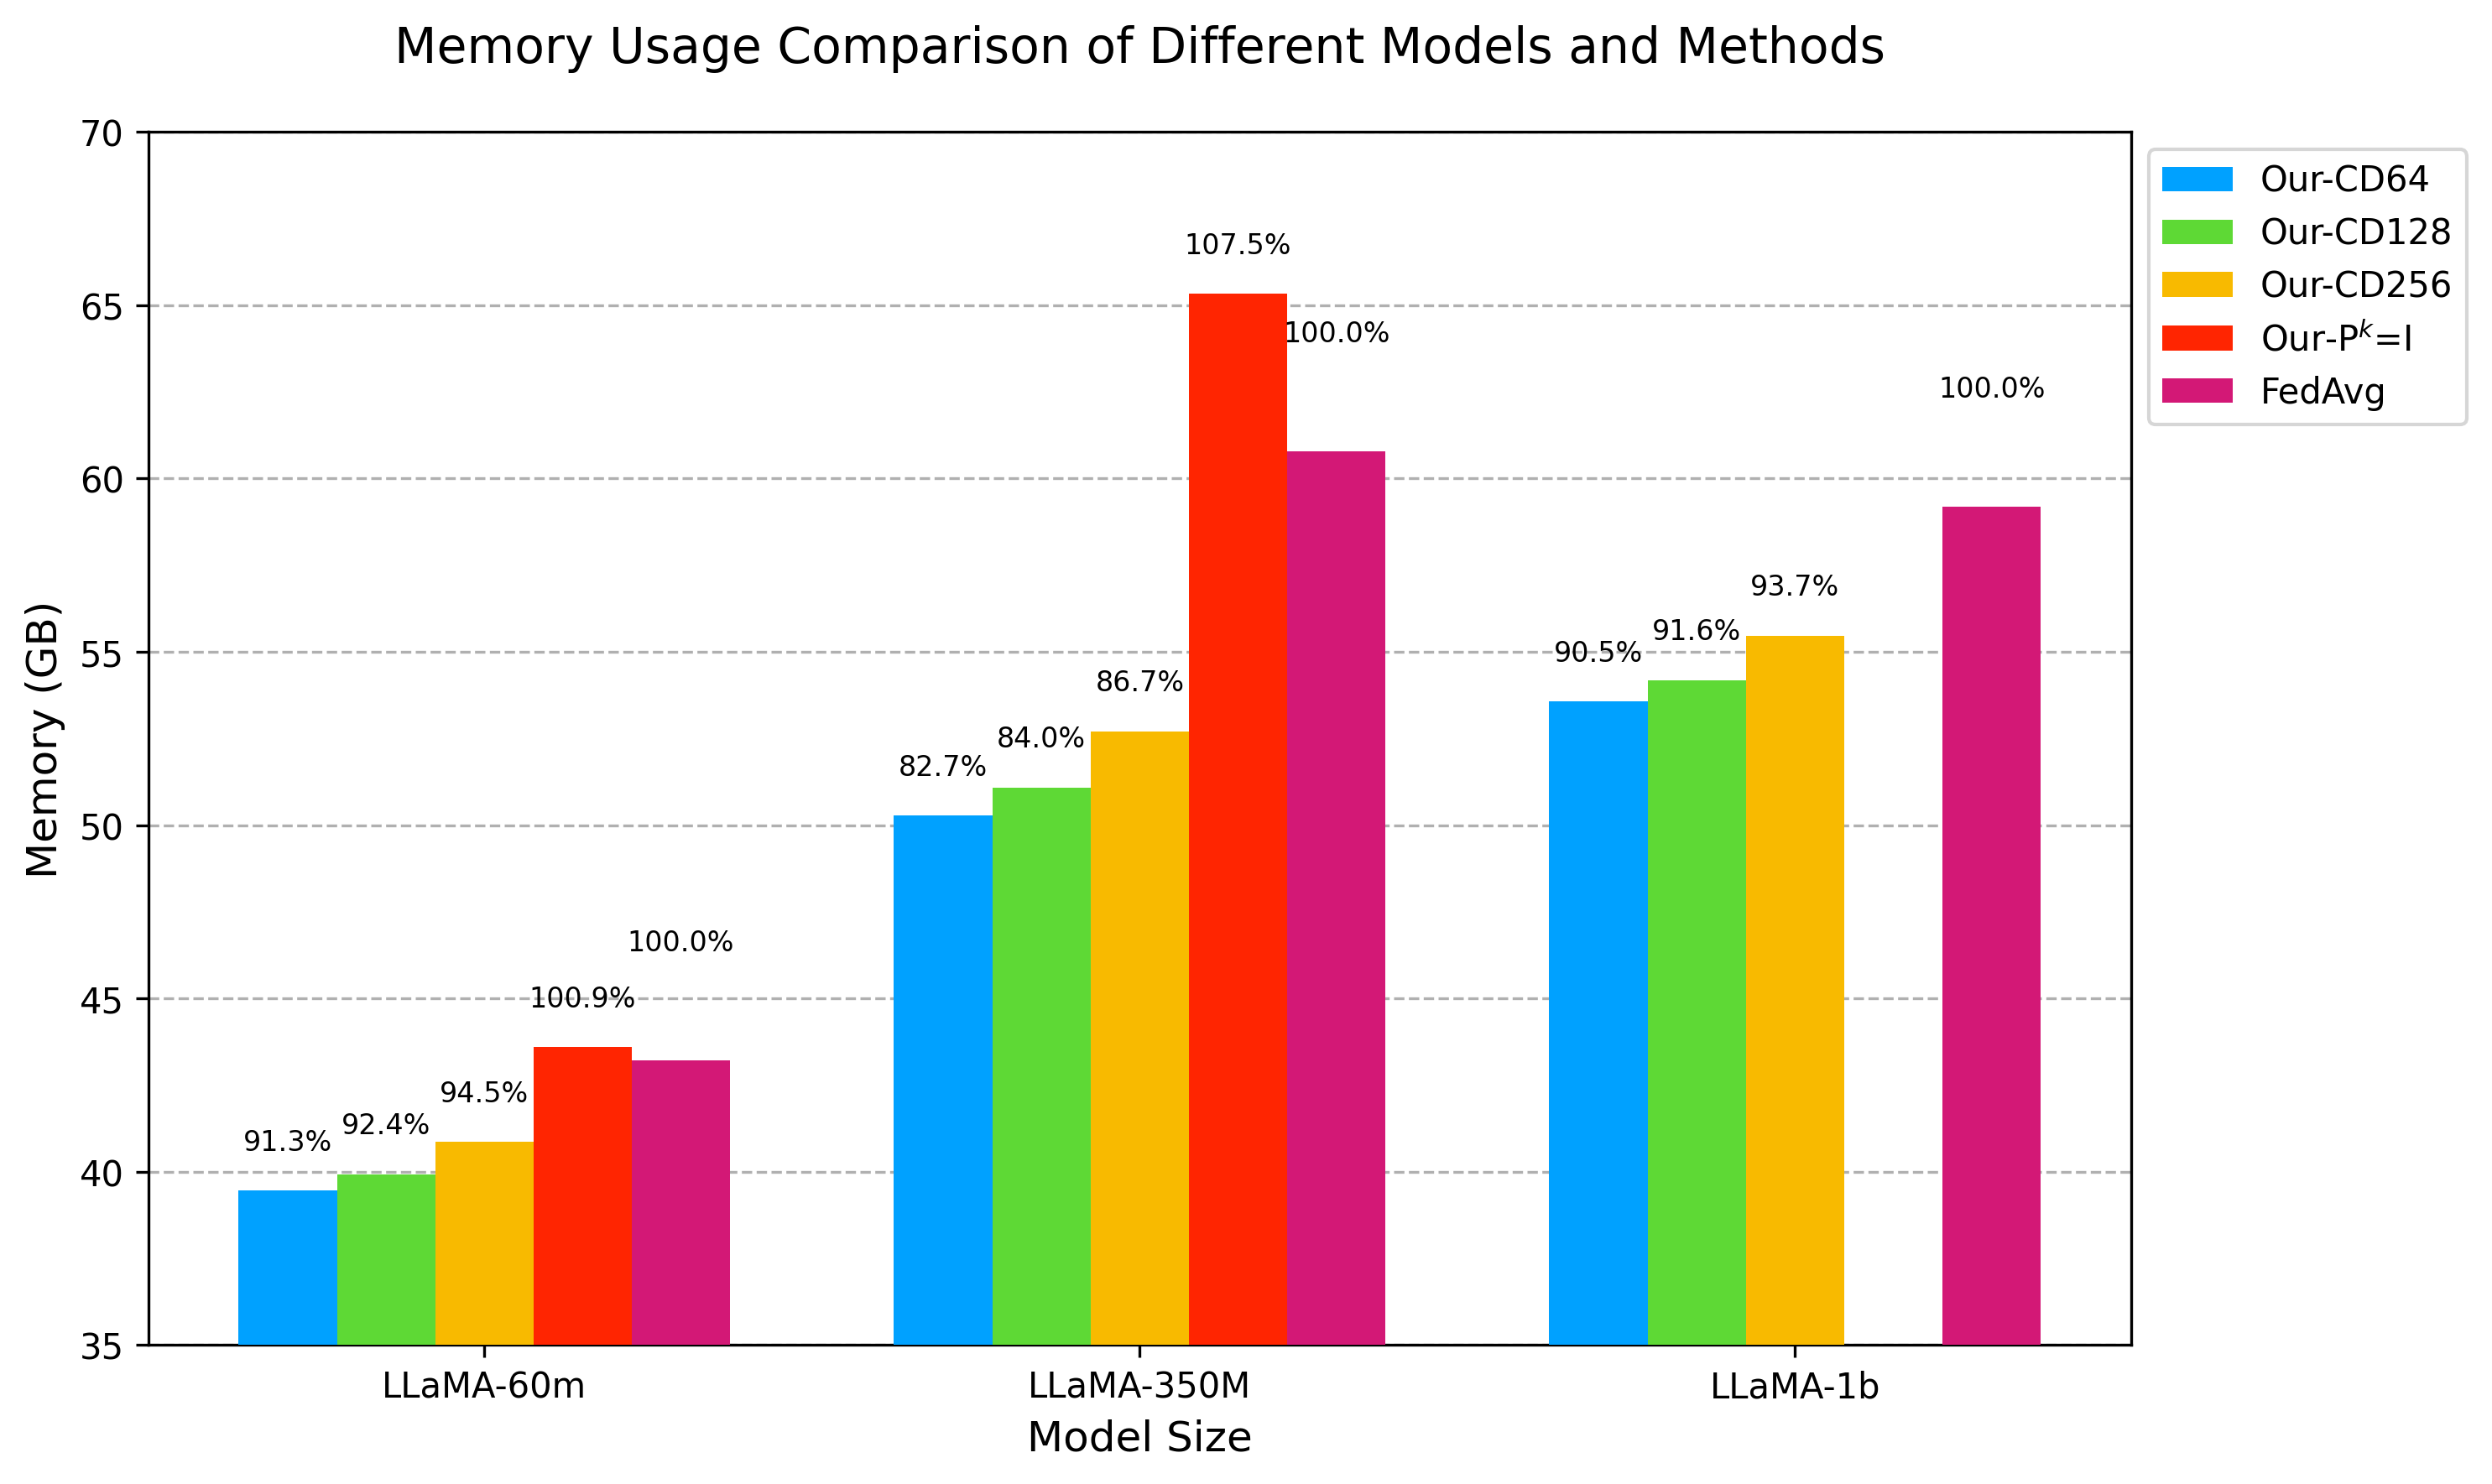

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 数据定义
model_name = ["LLaMA-60m", "LLaMA-350M", "LLaMA-1b"]
cd64_memory = [39.461, 50.272, 53.566]
cd128_memory = [39.924, 51.087, 54.184]
cd256_memory = [40.851, 52.705, 55.464]
pki_memory = [43.601, 65.324, np.nan]  # 将None替换为np.nan
fedavg_mem = [43.209, 60.785, 59.177]

# 合并所有算法数据
all_algorithms = {
    'Our-CD64': cd64_memory,
    'Our-CD128': cd128_memory,
    'Our-CD256': cd256_memory,
    r'Our-P$^k$=I': pki_memory,
    'FedAvg': fedavg_mem
}

# 计算各算法相对于FedAvg的内存占比（%）
def calculate_relative_ratio(algorithm_data, fedavg_data):
    ratios = []
    for alg_val, fed_val in zip(algorithm_data, fedavg_data):
        if np.isnan(fed_val) or fed_val == 0:
            ratios.append(np.nan)
        else:
            ratio = (alg_val / fed_val) * 100  # 计算占比百分比
            ratios.append(ratio)
    return ratios

# 计算所有算法的相对占比
all_ratios = {}
for alg_name, alg_data in all_algorithms.items():
    all_ratios[alg_name] = calculate_relative_ratio(alg_data, fedavg_mem)

# 设置图形大小和分辨率
plt.figure(figsize=(10, 6), dpi=300)

# 绘制柱状图并标注比例
x = np.arange(len(model_name))  # x轴位置
width = 0.15  # 柱子宽度
algorithms_order = ['Our-CD64', 'Our-CD128', 'Our-CD256', r'Our-P$^k$=I', 'FedAvg']
colors = ['#00A1FF', '#5ed935', '#f8ba00', '#ff2501', '#d31876']

bars = []
for i, alg_name in enumerate(algorithms_order):
    alg_data = all_algorithms[alg_name]
    bar = plt.bar(x - 2*width + i*width, alg_data, width, 
                 label=alg_name, color=colors[i], zorder=3)
    bars.append(bar)

    # 添加比例标注
    for j, ratio in enumerate(all_ratios[alg_name]):
        if not np.isnan(ratio):
            bar_height = bar[j].get_height()
            # 调整垂直位置，避免标签重叠
            vertical_offset = 1 if alg_name != 'FedAvg' else 3  # FedAvg标签稍高
            plt.text(bar[j].get_x() + bar[j].get_width()/2, 
                     bar_height + vertical_offset, 
                     f'{ratio:.1f}%', 
                     ha='center', va='bottom', fontsize=8, color='black')

# 设置图表标题和坐标轴标签
plt.title('Memory Usage Comparison of Different Models and Methods', fontsize=14, pad=20)
plt.xlabel('Model Size', fontsize=12)
plt.ylabel('Memory (GB)', fontsize=12)

# 设置x轴刻度和标签
plt.xticks(x, model_name, fontsize=10)

# 设置y轴范围和网格线
plt.ylim([35, 70])
plt.grid(axis='y', linestyle='--', zorder=0)

# 添加图例
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# 优化布局
plt.tight_layout()

# 保存图像并显示
plt.savefig("logs/csv/mem_ratio.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()